In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

#SAVING AND LOADING MODEL

In [2]:
df = pd.read_csv('../NSE_data_all_stocks_2022_jan_to_may (1).csv')
df

,Date,Code,Name,12m Low,12m High,Day Low,Day High,Day Price,Previous,Change,Change%,Volume,Adjusted Price
0,3-Jan-22,EGAD,Eaagads Ltd,10,15,13.5,13.8,13.5,13.5,-,-,"4,000",-
1,3-Jan-22,KUKZ,Kakuzi Plc,355,427,385,385,385,385,-,-,-,-
2,3-Jan-22,KAPC,Kapchorua Tea Kenya Plc,80,101,99.5,99.5,99.5,95.5,4,4.19%,100,-
3,3-Jan-22,LIMT,Limuru Tea Plc,260,360,320,320,320,320,-,-,-,-
4,3-Jan-22,SASN,Sasini Plc,16.75,22.6,18.7,18.7,18.7,18.7,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727,31-May-22,MSC,Mumias Sugar Company Ltd,0.27,0.27,0.27,0.27,0.27,0.27,-,-,-,-
6728,31-May-22,UNGA,Unga Group Ltd,26.1,36.4,29,29,29,30,-1,3.33%,"2,100",-
6729,31-May-22,SCOM,Safaricom Plc,25.5,45.25,25.95,26.45,26,26.25,-0.25,0.95%,"20,079,900",-
6730,31-May-22,FAHR,Stanlib Fahari Income-REIT,5,7.48,5.5,5.6,5.56,5.58,-0.02,0.36%,"11,700",-


In [3]:
#Custom Data cleaner 
import random
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler   
nsc_scaler = StandardScaler()

class NSEDataPreProcessor(BaseEstimator, TransformerMixin):
    
    def __init__(self,company_code ,columns_to_type_cast, columns_to_scale, columns_to_return):
        self.company_code = company_code        
        self.to_type_cast= columns_to_type_cast 
        self.to_return= columns_to_return
        self.to_scale=columns_to_scale  #same as  columns_to_type_cast but has the company code.
        
        
    def __type_cast_and_scale_xyz_df(self, xyz_data_frame):
        for column_name in self.to_type_cast:
            xyz_data_frame[column_name] = pd.to_numeric(xyz_data_frame[column_name], errors='coerce')
        xyz_data_frame[self.to_scale] = nsc_scaler.fit_transform(xyz_data_frame[self.to_scale])
        
        
        return xyz_data_frame[self.to_return]
    
    def fit(self, X, y=None):
        return self      

    def transform(self, X):  
        
        """
        X - NSC dataFrame
        Selects the data for one company , then names it xyz_company_data_frame 
        NB: Scaler always return columns that are assignable to the dataframe.        
        """        
        
        xyz_company_data_frame = X[X['Code'] == self.company_code].reset_index(drop=True)
        type_converted_xyz_company_df = self.__type_cast_and_scale_xyz_df(
            xyz_company_data_frame       
        )
        
        return type_converted_xyz_company_df
    
# 'Code','Day Price','Day High', 'Day High', '12m High', '12m Low' , 'Day Price','Day High', 'Day High', '12m High', '12m Low'

random_company_code = random.choice(df.Code)

#TPSE, UMME  giving the best results .
    
__nse_dat_preprocessor = NSEDataPreProcessor(
    company_code= 'TPSE',
    columns_to_type_cast=['Day Price','Day High', 'Day Low', '12m High', '12m Low'],
    columns_to_scale=[ 'Previous','Day High', 'Day Low', '12m High', '12m Low'],
    columns_to_return=['Code','Day Price','Previous','Day High', 'Day Low', '12m High', '12m Low'], 
)
xyz_preprocessed_df = __nse_dat_preprocessor.fit_transform(
    df,    
)
display(xyz_preprocessed_df.head(2)) #Show the company being worked on .

preprocessed_df = xyz_preprocessed_df.drop(columns=['Code'])
preprocessed_df
    

,Code,Day Price,Previous,Day High,Day Low,12m High,12m Low
0,TPSE,15.25,1.970978,1.981008,2.034167,0.0,0.0
1,TPSE,15.25,1.970978,1.981008,2.034167,0.0,0.0


,Day Price,Previous,Day High,Day Low,12m High,12m Low
0,15.25,1.970978,1.981008,2.034167,0.0,0.0
1,15.25,1.970978,1.981008,2.034167,0.0,0.0
2,15.25,1.970978,1.981008,2.034167,0.0,0.0
3,15.25,1.970978,1.981008,2.034167,0.0,0.0
4,15.25,1.970978,1.981008,2.034167,0.0,0.0
...,...,...,...,...,...,...
97,12.40,-0.757119,-0.493231,-0.319863,0.0,0.0
98,11.90,-0.421353,-0.840492,-1.063241,0.0,0.0
99,11.90,-0.841060,-0.883900,-1.063241,0.0,0.0
100,11.95,-0.841060,-0.883900,-0.691552,0.0,0.0


In [4]:
x_features = ['Previous','Day High', 'Day Low', '12m High', '12m Low']
x_single_feature =  'Day Price'
y_classes = 'Day Price'

X = preprocessed_df[x_single_feature]
day_price_df = preprocessed_df[x_single_feature]
day_price_df


0      15.25
1      15.25
2      15.25
3      15.25
4      15.25
       ...  
97     12.40
98     11.90
99     11.90
100    11.95
101    11.50
Name: Day Price, Length: 102, dtype: float64

# Using previous 4 days to  make predictions for the fifth day .

In [5]:
import utils.x_y_generator as generator
features , targets = generator.__generate_x_y_from_nsc_df(time_step=4, __data_frame=day_price_df)

print("X_Data shape : ",features.shape)
print("Y_Data shape : ",targets.shape)


column_names = ['Day1', 'Day2', 'Day3','Day4']


# Create a DataFrame with column names
df = pd.DataFrame(features, columns=column_names)

df['day_five_dayPrice'] = pd.Series(data= targets)
df


X_Data shape :  (98, 4)
Y_Data shape :  (98,)


,Day1,Day2,Day3,Day4,day_five_dayPrice
0,15.25,15.25,15.25,15.25,15.25
1,15.25,15.25,15.25,15.25,15.25
2,15.25,15.25,15.25,15.25,15.00
3,15.25,15.25,15.25,15.00,15.00
4,15.25,15.25,15.00,15.00,15.00
...,...,...,...,...,...
93,12.45,12.00,12.00,12.00,12.40
94,12.00,12.00,12.00,12.40,11.90
95,12.00,12.00,12.40,11.90,11.90
96,12.00,12.40,11.90,11.90,11.95


# Data Splitting : test and train data generation 

In [6]:
import utils.data_splitter as data_splitter

features_train, targets_train, features_test, targets_test = data_splitter.__dynamic_data_split(features,targets, ratio_train=0.8)

features_train.shape,targets_train.shape, features_test.shape, targets_test.shape

((78, 4), (78,), (20, 4), (20,))

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost

# Cross Validating Linear Regression model and XGBoost Regression.
### -------->>>> Allows us get a quick estimate on which model performs better on our dataset.
## 1.Linear Regressor

In [8]:
model = LinearRegression()

# Perform k-fold cross-validation for the L. regression model (let's say k=5)
cross_val_scores = cross_val_score(model, features, targets, cv=5, scoring='neg_mean_squared_error')

print("Linear Regression Cross-Validation Scores:", end=' ')
print(cross_val_scores)

average_score = np.mean(cross_val_scores)
print(f"\nAverage Performance Metric: {average_score:.2f}")


Linear Regression Cross-Validation Scores: [-0.35106341 -0.17799664 -0.13233947 -0.10458691 -0.16127328]

Average Performance Metric: -0.19


## 2. Extreme Gradient Boosting Regressor

In [9]:

model = xgboost.XGBRegressor(objective='reg:squarederror')  # Specifies regression objective

cross_val_scores = cross_val_score(model, features, targets, cv=5, scoring='neg_mean_squared_error')

print("Gradient Boosting Regressor Cross-Validation Scores:", end=' ')
print(cross_val_scores)

average_score = np.mean(cross_val_scores)
print(f"\nAverage Performance Metric: {average_score:.2f}")


Gradient Boosting Regressor Cross-Validation Scores: [-0.83366011 -0.23915034 -0.36879256 -0.12577928 -0.15214352]

Average Performance Metric: -0.34


In [10]:
base_model = xgboost.XGBRegressor(objective='reg:squarederror', random_state=42)

hyper_parameter_grid ={
    'n_estimators': [100, 200, 300,500,1000],
    'learning_rate': [0.01,0.15, 0.1, 0.2],
    'booster':['gbtree','gblinear'],
    'max_depth': [3, 5,7,15],
    'min_child_weight': [1, 3,5,7,9,10],

}
grid_search =RandomizedSearchCV(
    estimator=base_model, 
    param_distributions= hyper_parameter_grid,
    cv=5,
    n_iter=100, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)
# grid_search =GridSearchCV(estimator=base_model, param_grid= hyper_parameter_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(features_train, targets_train)


/home/kering/Desktop/MachineLearningProjects/KnowledgeBasedSystemsML/KnowledgeBasedSystemsVenv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:18:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth", "min_child_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kering/Desktop/MachineLearningProjects/KnowledgeBasedSystemsML/KnowledgeBasedSystemsVenv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:18:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth", "min_child_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kering/Desktop/MachineLearningProjects/KnowledgeBasedSystemsML/KnowledgeBasedSystemsVenv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:18:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth", "min_child_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/kering/Desktop/MachineLearningProjects/KnowledgeBasedSystemsML/Knowled

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [0.01, 0.15, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 15],
                                        'min_child_weight': [1, 3, 5, 7, 9, 10],
                                        'n_estimators': [100, 200, 300, 500,
                                                         1000]},
                   scoring='neg_mean_squared_error')

In [11]:
best_params = grid_search.best_params_
best_params

{'n_estimators': 300,
 'min_child_weight': 7,
 'max_depth': 15,
 'learning_rate': 0.01,
 'booster': 'gbtree'}

In [12]:
grid_search_cv_best_results = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.01,
    'max_depth': 5,
    'min_child_weight': 5,
    'n_estimators': 300,
    'subsample': 1.0
}
final_model = xgboost.XGBRegressor(objective='reg:squarederror', random_state=42, **best_params)
final_model.fit(features_train, targets_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [13]:
import pandas as pd

predicted_stock_prices = final_model.predict(features_test)
resultDf = pd.DataFrame(data = {
    'Actual':targets_test,
    'Predictions':predicted_stock_prices.flatten(),    
})
resultDf

,Actual,Predictions
0,12.55,12.085120
1,12.45,12.437201
2,12.45,12.272093
3,11.75,12.388473
4,12.00,11.809022
5,13.10,12.207005
6,12.00,12.813532
7,12.00,12.016894
8,12.45,12.214931
9,12.45,12.391109


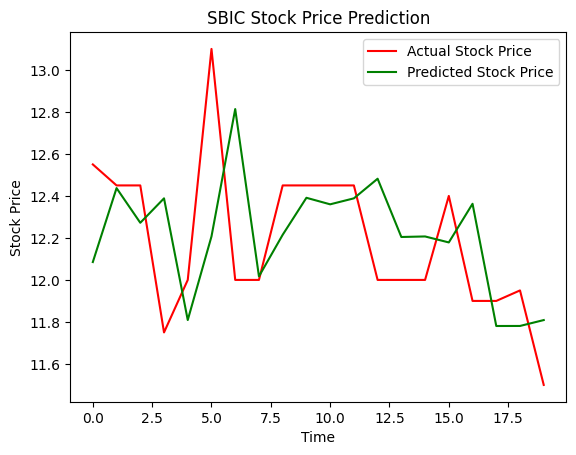

In [14]:
import matplotlib.pyplot as plt 
plt.plot(targets_test, color = 'red', label = 'Actual Stock Price')
plt.plot(predicted_stock_prices, color = 'green', label = 'Predicted Stock Price')
plt.title(random_company_code + ' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
